## Imports

In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import os
import time
from datetime import timedelta

C:\Users\lzcai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Set Parameter

In [29]:
# Initialize Values
NUM_FEATURES = 36
NUM_CLASSES = 6
NUM_HIDDEN = 10

LEARNING_RATE = 0.01
EPOCHS = 5000
BATCH_SIZE = 32
NUM_NEURONS = 10
SEED = 10
BETA = pow(10, -6)
np.random.seed(SEED)
DROP = True

TRAIN_FILE_NAME = 'sat_train.txt'
TEST_FILE_NAME = 'sat_test.txt'

## Load Data

In [3]:
# scale data
def scale(X, X_min, X_max):
    return (X - X_min)/(X_max-X_min)

def process_inputs_from_file(fileName): # Read in data
    inputs = np.loadtxt(fileName, delimiter=' ')
    X, _Y = inputs[:, :NUM_FEATURES], inputs[:, -1].astype(int)
    X = scale(X, np.min(X, axis=0), np.max(X, axis=0))
    _Y[_Y == 7] = 6 # Actually dont have, just in case have error data

    Y = np.zeros((_Y.shape[0], NUM_CLASSES))
    Y[np.arange(_Y.shape[0]), _Y - 1] = 1 #one hot matrix
    return X, Y

In [4]:
trainX, trainY = process_inputs_from_file(TRAIN_FILE_NAME)
testX, testY = process_inputs_from_file(TEST_FILE_NAME)

In [5]:
print ("Size of:")
print("- Training-set\t\t",len(trainX))
print("- Test-set\t\t",len(testX))

Size of:
- Training-set		 4435
- Test-set		 2000


## Tensorflow Graph

There are 3 layers in this graph, namely one input-layer(X), one hidden-layer(W, b) and one output-layer(V, c).

The output does not scale to [0, 1] and I dont know why.

### Placeholder Variables

In [6]:
x = tf.placeholder(tf.float32, [None, NUM_FEATURES], name='x')
d = tf.placeholder(tf.float32, [None, NUM_CLASSES], name='d')

### Create Network

In [7]:
def init_weights(feature_no, neuron_no, name, logistic = True):
    # From eg.5.2
    n_in = feature_no
    n_out = neuron_no
    W_values = np.asarray(np.random.uniform(low=-np.sqrt(6. / (n_in + n_out)),
                                            high=np.sqrt(6. / (n_in + n_out)),
                                            size=(n_in, n_out)))
    if logistic == True:
        W_values *= 4
    return(tf.Variable(W_values, dtype=tf.float32, name=name))

def init_bias(neuron_no, name):
    # From eg.5.2
    return(tf.Variable(np.zeros(neuron_no), dtype=tf.float32, name=name))

In [8]:
with tf.variable_scope("Hidden_layer"):
    W = init_weights(NUM_FEATURES, NUM_HIDDEN, name="Weight_1")
    b = init_bias(NUM_HIDDEN, name="Bias_1")
    z = tf.matmul(x, W) + b #syn_input_1
    h = tf.nn.sigmoid(z) #out_1

with tf.variable_scope("Output_layer"):
    V = init_weights(NUM_HIDDEN, NUM_CLASSES, name="Weight_2")
    c = init_bias(NUM_CLASSES, name="Bias_2" )
    u = tf.matmul(h, V) + c #syn_out_2
    y = tf.nn.sigmoid(u) #out_2  # Consider to change to sigmoid

### Performance Measures

In [9]:
def setup_cross_entropy(labels, logits):
    return tf.nn.softmax_cross_entropy_with_logits_v2(labels=labels, logits=logits)

def setup_correct_prediction(labels, logits):
    return tf.cast(tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1)), tf.float32)

In [10]:
cross_entropy = setup_cross_entropy(labels=d, logits=y)
regularization = tf.nn.l2_loss(V) + tf.nn.l2_loss(W) 
J = tf.reduce_mean(cross_entropy + BETA * regularization)

In [11]:
correct_prediction = setup_correct_prediction(labels=d, logits=y)
accuracy = tf.reduce_mean(correct_prediction)

### Optimization Method

In [12]:
optimizer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
train_op = optimizer.minimize(J)

### Saver

In [13]:
saver = tf.train.Saver()

In [14]:
save_dir = "Z:\Github\CZ4042\save"
if not os.path.exists(save_dir):
    print("Not Exist")
    os.makedirs(save_dir)

In [15]:
drop_str = "-Drop" if DROP else "-Not_Drop"

save_path = os.path.join(save_dir, str(EPOCHS)+ '-'+ str(BATCH_SIZE)+'-sigmoid')

In [16]:
save_path

'Z:\\Github\\CZ4042\\save\\5000-32-sigmoid'

## TensorFlow Run

### Create TensorFlow Session

In [17]:
session = tf.Session()

### Initialize variables

In [18]:
def init_variables():
    session.run(tf.global_variables_initializer())

In [19]:
init_variables()

### Helper-function to perform optimization iterations

In [20]:
# Best validation accuracy seen so far.
best_validation_accuracy = 0.0

# Iteration-number for last improvement to validation accuracy.
last_improvement = 0

# Stop optimization if no improvement found in this many iterations.
require_improvement = 1000

### Helper-function to generate next_batch

In [21]:
def next_batch(num, data, labels):
    '''
    Return a total of `num` random samples and labels. 
    '''
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

BATCH_SIZE= 64
iter 0: Train accuracy 0.28125 Test accuracy:  0.235 *
iter 100: Train accuracy 0.671875 Test accuracy:  0.626 *
iter 200: Train accuracy 0.734375 Test accuracy:  0.6295 *
iter 300: Train accuracy 0.71875 Test accuracy:  0.6305 *
iter 400: Train accuracy 0.640625 Test accuracy:  0.6335 *
iter 500: Train accuracy 0.65625 Test accuracy:  0.634 *
iter 600: Train accuracy 0.703125 Test accuracy:  0.6345 *
iter 700: Train accuracy 0.71875 Test accuracy:  0.6345 
iter 800: Train accuracy 0.703125 Test accuracy:  0.637 *
iter 900: Train accuracy 0.703125 Test accuracy:  0.637 
iter 1000: Train accuracy 0.625 Test accuracy:  0.6395 *
iter 1100: Train accuracy 0.65625 Test accuracy:  0.642 *
iter 1200: Train accuracy 0.71875 Test accuracy:  0.6415 
iter 1300: Train accuracy 0.546875 Test accuracy:  0.6445 *
iter 1400: Train accuracy 0.734375 Test accuracy:  0.6465 *
iter 1500: Train accuracy 0.703125 Test accuracy:  0.65 *
iter 1600: Train accuracy 0.71875 Test accuracy:  0.654 *

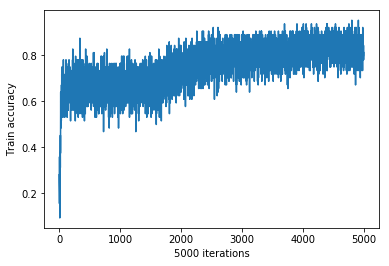

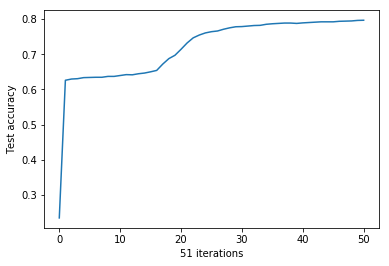

BATCH_SIZE= 32
iter 0: Train accuracy 0.125 Test accuracy:  0.235 *
iter 100: Train accuracy 0.65625 Test accuracy:  0.6295 *
iter 200: Train accuracy 0.6875 Test accuracy:  0.634 *
iter 300: Train accuracy 0.78125 Test accuracy:  0.6335 
iter 400: Train accuracy 0.6875 Test accuracy:  0.637 *
iter 500: Train accuracy 0.71875 Test accuracy:  0.64 *
iter 600: Train accuracy 0.6875 Test accuracy:  0.641 *
iter 700: Train accuracy 0.71875 Test accuracy:  0.647 *
iter 800: Train accuracy 0.65625 Test accuracy:  0.6545 *
iter 900: Train accuracy 0.6875 Test accuracy:  0.684 *
iter 1000: Train accuracy 0.75 Test accuracy:  0.716 *
iter 1100: Train accuracy 0.71875 Test accuracy:  0.747 *
iter 1200: Train accuracy 0.875 Test accuracy:  0.7605 *
iter 1300: Train accuracy 0.875 Test accuracy:  0.766 *
iter 1400: Train accuracy 0.71875 Test accuracy:  0.7745 *
iter 1500: Train accuracy 0.9375 Test accuracy:  0.78 *
iter 1600: Train accuracy 0.84375 Test accuracy:  0.7825 *
iter 1700: Train accur

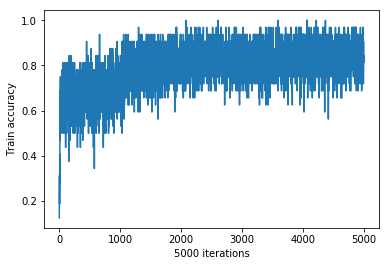

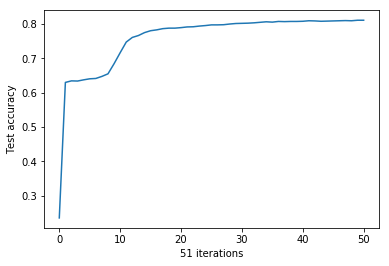

BATCH_SIZE= 16
iter 0: Train accuracy 0.0625 Test accuracy:  0.235 *
iter 100: Train accuracy 0.625 Test accuracy:  0.633 *
iter 200: Train accuracy 0.625 Test accuracy:  0.6355 *
iter 300: Train accuracy 0.6875 Test accuracy:  0.6415 *
iter 400: Train accuracy 0.75 Test accuracy:  0.654 *
iter 500: Train accuracy 0.6875 Test accuracy:  0.7155 *
iter 600: Train accuracy 0.75 Test accuracy:  0.76 *
iter 700: Train accuracy 0.875 Test accuracy:  0.7745 *
iter 800: Train accuracy 0.625 Test accuracy:  0.7835 *
iter 900: Train accuracy 0.9375 Test accuracy:  0.7855 *
iter 1000: Train accuracy 0.625 Test accuracy:  0.789 *
iter 1100: Train accuracy 0.8125 Test accuracy:  0.7915 *
iter 1200: Train accuracy 0.75 Test accuracy:  0.7955 *
iter 1300: Train accuracy 0.75 Test accuracy:  0.797 *
iter 1400: Train accuracy 0.75 Test accuracy:  0.8005 *
iter 1500: Train accuracy 0.875 Test accuracy:  0.8015 *
iter 1600: Train accuracy 0.9375 Test accuracy:  0.803 *
iter 1700: Train accuracy 0.6875 Te

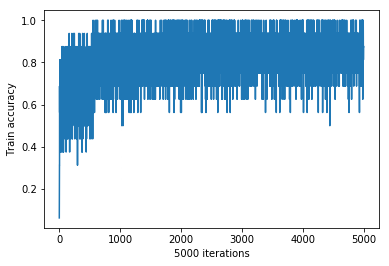

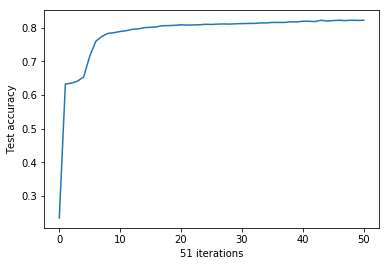

BATCH_SIZE= 8
iter 0: Train accuracy 0.125 Test accuracy:  0.235 *
iter 100: Train accuracy 0.375 Test accuracy:  0.6335 *
iter 200: Train accuracy 0.5 Test accuracy:  0.656 *
iter 300: Train accuracy 0.625 Test accuracy:  0.762 *
iter 400: Train accuracy 0.875 Test accuracy:  0.7825 *
iter 500: Train accuracy 0.875 Test accuracy:  0.7885 *
iter 600: Train accuracy 0.875 Test accuracy:  0.7945 *
iter 700: Train accuracy 0.875 Test accuracy:  0.7995 *
iter 800: Train accuracy 0.75 Test accuracy:  0.8045 *
iter 900: Train accuracy 0.75 Test accuracy:  0.8075 *
iter 1000: Train accuracy 1 Test accuracy:  0.81 *
iter 1100: Train accuracy 0.875 Test accuracy:  0.8085 
iter 1200: Train accuracy 1 Test accuracy:  0.811 *
iter 1300: Train accuracy 1 Test accuracy:  0.8115 *
iter 1400: Train accuracy 1 Test accuracy:  0.812 *
iter 1500: Train accuracy 0.875 Test accuracy:  0.8115 
iter 1600: Train accuracy 0.875 Test accuracy:  0.813 *
iter 1700: Train accuracy 1 Test accuracy:  0.8155 *
iter 1

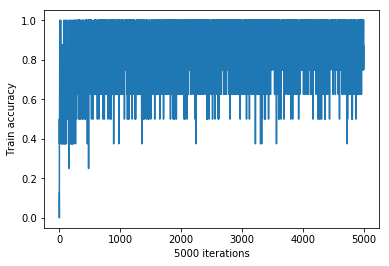

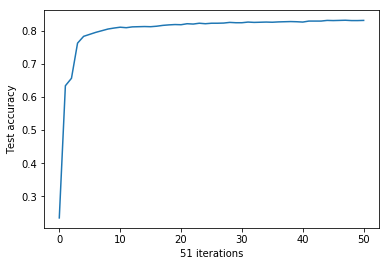

BATCH_SIZE= 4
iter 0: Train accuracy 0.75 Test accuracy:  0.312 *
iter 100: Train accuracy 0.5 Test accuracy:  0.651 *
iter 200: Train accuracy 0.75 Test accuracy:  0.7795 *
iter 300: Train accuracy 1 Test accuracy:  0.795 *
iter 400: Train accuracy 1 Test accuracy:  0.805 *
iter 500: Train accuracy 1 Test accuracy:  0.809 *
iter 600: Train accuracy 1 Test accuracy:  0.8095 *
iter 700: Train accuracy 1 Test accuracy:  0.813 *
iter 800: Train accuracy 1 Test accuracy:  0.813 
iter 900: Train accuracy 0.75 Test accuracy:  0.8145 *
iter 1000: Train accuracy 0.75 Test accuracy:  0.8215 *
iter 1100: Train accuracy 0.75 Test accuracy:  0.819 
iter 1200: Train accuracy 1 Test accuracy:  0.8215 
iter 1300: Train accuracy 1 Test accuracy:  0.8235 *
iter 1400: Train accuracy 0.75 Test accuracy:  0.825 *
iter 1500: Train accuracy 1 Test accuracy:  0.8245 
iter 1600: Train accuracy 1 Test accuracy:  0.825 
iter 1700: Train accuracy 0.75 Test accuracy:  0.8235 
iter 1800: Train accuracy 1 Test accu

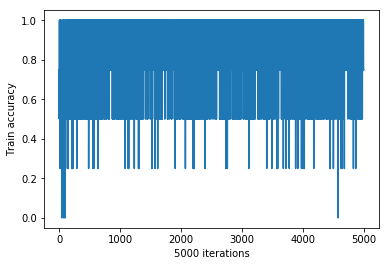

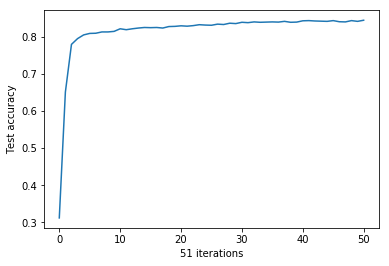

In [31]:
for BATCH_SIZE in [64, 32, 16, 8, 4]:
# Counter for total number of iterations performed so far.
    init_variables()
    print("BATCH_SIZE=", BATCH_SIZE)
    total_iterations = 0
    train_acc = []
    save_path = os.path.join(save_dir, str(EPOCHS)+ '-'+ str(BATCH_SIZE)+'-sigmoid')
    
    with session.as_default():
        # Ensure we update the global variables rather than local copies.

        # Start-time used for printing time-usage below.
        start_time = time.time()
        train_acc_record = []
        test_acc_record = []
        best_test_acc = 0.0
        last_improvement = 0
        improved_str = ""
        test_count = 0
        mul = int(len(trainX)/BATCH_SIZE)
        for i in range(EPOCHS):
            for j in range(mul):
                x_batch, d_batch = next_batch(BATCH_SIZE, trainX, trainY)
                feed_dict_train = {x: x_batch, d: d_batch}
                session.run(train_op, feed_dict=feed_dict_train)

            train_acc_record.append(accuracy.eval(feed_dict=feed_dict_train))


            if i % 100 == 0 or i == (EPOCHS - 1):
                test_count += 1
                test_accuracy = session.run(accuracy, feed_dict={x: testX, d: testY})
                test_acc_record.append(test_accuracy)
                if DROP:
                    if test_accuracy > best_test_acc:
                        best_test_acc = test_accuracy
                        last_improvement = i
                        saver.save(sess=session, save_path=save_path)
                        improved_str = "*"
                    else:
                        improved_str = ''
                else:
                    saver.save(sess=session, save_path=save_path)

                print('iter %d: Train accuracy %g'%(i, train_acc_record[i]), 'Test accuracy: ',test_accuracy, improved_str)



        # Ending time.
        end_time = time.time()

        # Difference between start and end-times.
        time_dif = end_time - start_time

        # Print the time-usage.
        print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

        plot_train(EPOCHS, BATCH_SIZE, train_acc_record)
        plot_test(test_count, BATCH_SIZE, test_acc_record)

### Helper-function to plot train accuracy

In [23]:
def plot_train(EPOCHS, BATCH_SIZE, train_acc_record):
    plt.figure(1)
    plt.plot(range(EPOCHS), train_acc_record)
    plt.xlabel(str(EPOCHS) + ' iterations')
    plt.ylabel('Train accuracy')
    plt.savefig("PartA-Train"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png")
    plt.show()

In [24]:
def plot_test(EPOCHS, BATCH_SIZE, test_acc_record):
    plt.figure(1)
    plt.plot(range(EPOCHS), test_acc_record)
    plt.xlabel(str(EPOCHS) + ' iterations')
    plt.ylabel('Test accuracy')
    plt.savefig("PartA-Test"+str(EPOCHS)+'-'+str(BATCH_SIZE)+".png")
    plt.show()

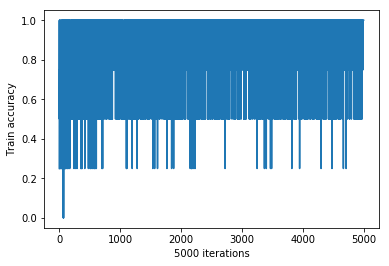

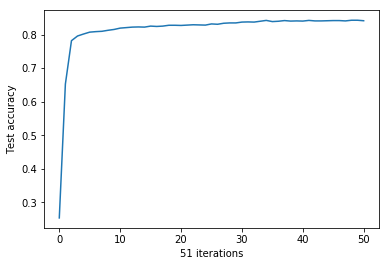

In [25]:
plot_train(EPOCHS, BATCH_SIZE, train_acc_record)
plot_test(test_count, BATCH_SIZE, test_acc_record)

### Helper-function of validation

In [25]:
def validation_accuracy(testX, testY):
    output_2_, accuracy_ = session.run([y, accuracy], feed_dict={x: testX, d: testY})
    print(output_2_, '\n',accuracy_)

In [70]:
output_2_

array([[2.9397753e-01, 4.3548190e-04, 9.7745150e-01, 8.5959199e-04,
        4.6248853e-04, 7.7723754e-03],
       [4.3027911e-01, 5.2449387e-04, 9.7516578e-01, 8.1718847e-04,
        4.9770542e-04, 5.6805746e-03],
       [6.8876721e-02, 3.3670937e-04, 9.6314240e-01, 9.5290109e-04,
        9.4554748e-04, 6.1859578e-02],
       ...,
       [8.9659494e-01, 3.5728902e-02, 1.1459270e-03, 1.6782280e-03,
        2.1114142e-01, 1.4932638e-03],
       [8.4805685e-01, 9.2608012e-02, 6.9726224e-04, 2.4266716e-03,
        3.0625769e-01, 1.5714751e-03],
       [8.7434644e-01, 2.4730316e-01, 1.5030775e-03, 2.5115125e-03,
        2.4306813e-01, 2.2728051e-04]], dtype=float32)

In [27]:
x_batch, d_batch = next_batch(BATCH_SIZE, trainX, trainY)

In [29]:
d_batch

array([[0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1.